# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd


Text(0.5,1,'magnitude spectrogram')

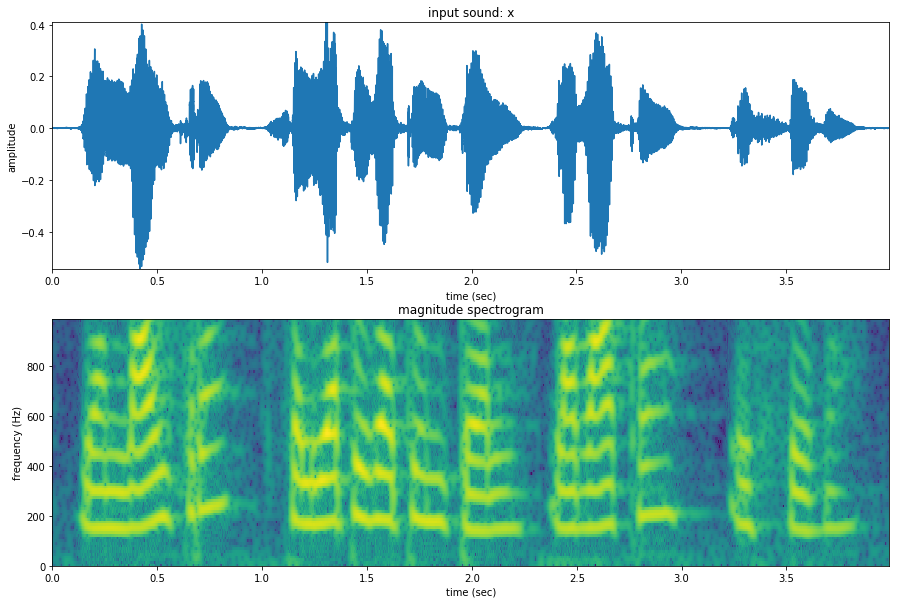

In [2]:
##### basic visualization and listening of sound
input_file = '../sounds/speech-female.wav'

### set parameters
window = 'hamming'
M = int(4*44100/80)
N = 2**int(np.ceil(np.log2(M)))
H = 128

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### 1.1 Describe sound

In [3]:
# analysis and synthesis of sound using the HPS model
input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='blackman'
M = int(6*44100/150)-1
N = 2**int(np.ceil(np.log2(M)))
t = -100
minSineDur = 0.01
nH = 100
minf0 = 100
maxf0 = 300
f0et = 5
harmDevSlope = 0.01
stocf = 0.6

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

print("Original Audio")
ipd.display(ipd.Audio(data=x, rate=fs))
print("Output HPS model")
ipd.display(ipd.Audio(data=y, rate=fs))
print("\n\n Output Harmonic model")
ipd.display(ipd.Audio(data=yh, rate=fs))
print("Output Stochastic model")
ipd.display(ipd.Audio(data=yst, rate=fs))

Original Audio


Output HPS model




 Output Harmonic model


Output Stochastic model


### 1.2 Explain the analysis

1) Window = Blackman: we want high time resolution but also a window with low SNR to do an appropiate reading of
the ideal peaks.

2) M = 1763: we need a good time resolution in order to track all the speech, therefore a small M would be prefered

3) N = 2048: as the algorithm uses parabolic interpolation, no extra interpolation by zero-padding is needed. Only 285 samples are interpolated in each frame.

4) t = -100: To detect all the harmonics of the sound and have a good quality output, high frequency harmonics must be detected, hence a small amplitude threshold must be selected.

5) minSineDur = 0.01: based on the magnitude spectrogram, the minimum length of the harmonics is selected (and to ensure that all of them would be read a smaller time is chosen)

6) nH = 100: a high amount of harmonics to be sure that we are detecting all of them.

7) minf0 = 100 and maxf0 = 300 :  analyzing the STFT and focusing on the lowest frequency of the spectrum that range is chosen. 

9) f0et = 5: Because we dont have that much frequency resolution, the error commited in harmonics peak detection would be higher, therefore a decent amount of frequency prediction error by the TWM algorithm must be introduced. 

10) harmDevSlope = 0.01: default "harmDevSlope" to allow some deviation in the detection of the harmonics.

11) stocf = 0.6: to get the stochastic sounds of the sound (part of the "s" and the reverb of the sound) a relative high "stocf" is needed because this sound has majoritary part of low frequency components. Therefore a relative high downsampling factor is needed so that those low frequency stochastic signals that the sample has are processed. 


## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [2]:
# 2.1 download the sound from freesound, read it with waveread
# Link of download: https://freesound.org/people/k2tr/sounds/104181/

#### your code here
input_file = '../sounds/vinyl-piano.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""Reverb piano sound with a characterisic vinyl noise. The sound has been selected because it has a harmonic and
monophonic component (that can be synthesize by Harmonic Model) and a stochastic component which is the typical 
sound of the noise introduce by vinyl (that can be synthesize by the Stochastic Model)"""

'Reverb piano sound with a characterisic vinyl noise. The sound has been selected because it has a harmonic and\nmonophonic component (that can be synthesize by Harmonic Model) and a stochastic component which is the typical \nsound of the noise introduce by vinyl (that can be synthesize by the Stochastic Model)'

'Piano melody starts in a low pitch around 125Hz and the maximum frequency of the melody is around 260Hz\ntherefore the range for finding the f0 for the Harmonic Model should be [100,300] to ensure that the frequency\nis going to be there. Because we have noise in the back and we dont want to read undesirable harmonics, the \nnumber of harmonics that should be process should be around 10, no more than 20.'

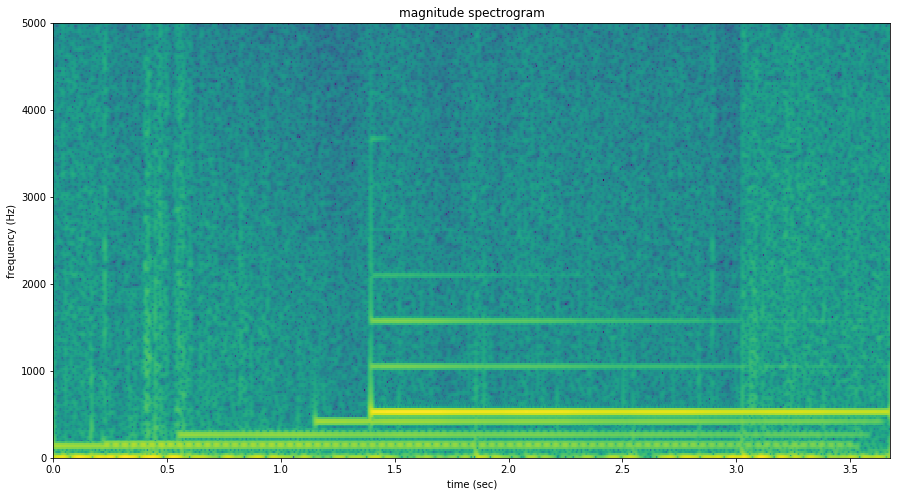

In [15]:
# Part 2.2 basic visualization and listening of sound

### basic visualization and listening of sound
input_file = '../sounds/vinyl-piano.wav'
window = 'blackman'
M = 2047
N = 2**int(np.ceil(np.log2(M)))
H = 126

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')


### describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""Piano melody starts in a low pitch around 125Hz and the maximum frequency of the melody is around 260Hz
therefore the range for finding the f0 for the Harmonic Model should be [100,300] to ensure that the frequency
is going to be there. Because we have noise in the back and we dont want to read undesirable harmonics, the 
number of harmonics that should be process should be around 10, no more than 20."""


In [ ]:
# Part 3.3 analysis and synthesis of sound using the HPS model

### fill the parameters
input_file = '../sounds/vinyl-piano.wav'
window ='blackman'
M = 2047
N = 2**int(np.ceil(np.log2(M)))
t = -100
minSineDur = 0.15
nH = 10 
minf0 = 100
maxf0 = 300
f0et = 5
harmDevSlope = 0
stocf = 0.2

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

print(yst.size)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

### ANALYSIS OF THE SYNTH SOUND

# The recovery of the sound it is not as we wanted. Due to the presence of a a biiger source of noise there is
# a small change in the pitch when it should not be when noise appears on the signal (around 3.5 seconds of the
# sample)

### Explain the choices of parameters

"""Window = Blackman: good for time and frequency resolution trade-off.

M = 2047: to have good time and frequency resolution.

N = 2048: next power of two nº of M, because no extra interpolation is needed.

t = -100: optimum value to be able to detect all the peaks of the harmonic sound.

minSineDur = 0.15: relatively high value to avoid vinyl noise partials tracking, instead of the harmonics of the
sound.

nH = 10: low value of harmonic to avoid vinyl noise partials detection as harmonics of the piano.

minf0 = 100 and maxf0 = 300: range where the fundamental frequencies of the melody of the piano are placed.

f0et = 5: not too low because a piano is being analyzed (inharmonics) but not too high because only 10 harmonics
are being processed

harmDevSlope = 0: because of the presence of noise, we want the least deviation allowance in the harmonic detection
to not read undesirable harmonics.

stocf = 0.2: high downsampling factor because with the Stochastic Model the noise of the vinyl is the target. And 
this noise has medium-high and high frequency values. If a low downsampling factor is applied the stochastic signal
synthesized would have high frequency resolution and therefore some components in the low frequencies, which would
change the pitch of the sound. A low downsampling factor could be applied if a perceptual synthesis of the stochastic
signal is applied."""


 # ADITIONAL - Posible improvement of software
 
A propose method to downsample based on our frequencies perception is implemented. Instead of using resample function, an exponential reading (power of two) of the original array is done. IT IS IMPLEMENTED ONLY FOR DOWNSAMPLING.

The algorithm is sustain by the formula:

\begin{eqnarray}
M = \frac{20*2^{\frac{i*10}{stocf*N}}}{fres}
\end{eqnarray}



In [38]:
def human_percep_downsample (mX, stocf):
    """
    mX: input spectrum
    stocf: downsampling rate [0,1]
    """
    N = mX.size
    mY = np.zeros(int(stocf*N))
    for i in range (int(stocf*N)):
        fres = 20*2**10/N                                     #20*2**10 = 20480
        j = int(np.floor((20*2**((i*10)/(stocf*N)))/fres))  
        mY[i] = mX[j]
                       
    return mY

To demonstrate it works an example it is shown. 

**Case 1** : Vector of 20,000 samples with the same values as their spot in the array and a **stocf = 0.5** it is applied. 
Original array and output array are plotted to show the exponential downsample that it is done. Also the output array is plotted with the logaritmic scale feature of matplotlib to demonstrate its logaritmic shape obtaining a linear function.

**Case 2** : Vector of 5,000 samples with the same values as their spot in the array and a **stocf = 0.25** it is applied. Original array and output array are plotted to show the exponential downsample that it is done. Also the output array is plotted with the logaritmic scale feature of matplotlib to demonstrate its logaritmic shape obtaining a linear function.

Text(0.5,1,'Output array logaritmic verification')

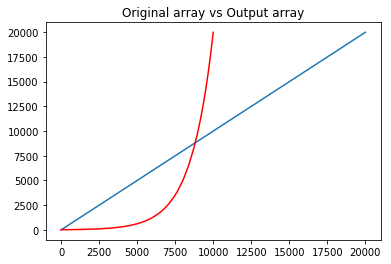

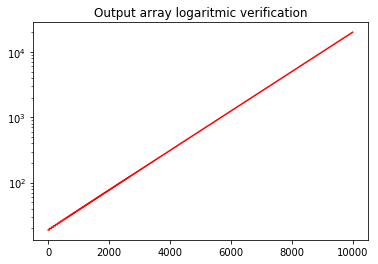

In [37]:
x = np.arange(20000)
stocf = 0.5

y = human_percep_downsample(x,stocf)

plt.plot(x)
plt.plot(y,'r')
plt.title('Original array vs Output array')


plt.figure()
plt.plot(y,'r')
plt.yscale('log')
plt.title('Output array logaritmic verification')

Text(0.5,1,'Output array logaritmic verification')

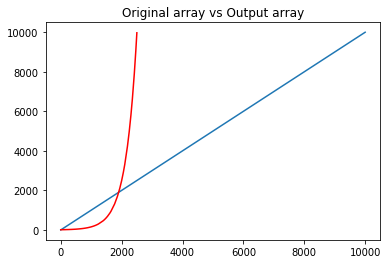

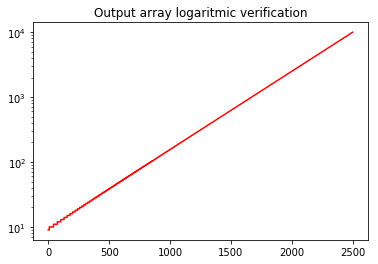

In [36]:
x = np.arange(10000)
stocf = 0.25

y = human_percep_downsample(x,stocf)

plt.figure()
plt.plot(x)
plt.plot(y,'r')
plt.title('Original array vs Output array')

plt.figure()
plt.plot(y,'r')
plt.yscale('log')
plt.title('Output array logaritmic verification')

### CONCLUSION

Using this fucntion allows to achieve a downsample based on our frequency perception.